<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/MLT-x-fastai/blob/master/mini-lessons/vision/image_enhancement_gan-5k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [ ]:
#get data
#!wget https://raw.githubusercontent.com/yuanming-hu/exposure/master/fetch_fivek.py
#!python fetch_fivek.py

In [3]:
path  = Path('data/artists/')

In [ ]:
path.ls()

In [5]:
from PIL import ImageEnhance

def aug_multi(img, steps,func=None):
    width, height = img.size
    canvas = PIL.Image.new('RGB', (width * len(steps), height))
    for n, level in enumerate(steps):
        img_filtered = func(img).enhance(level)
        canvas.paste(img_filtered, (width * n, 0))
    return canvas


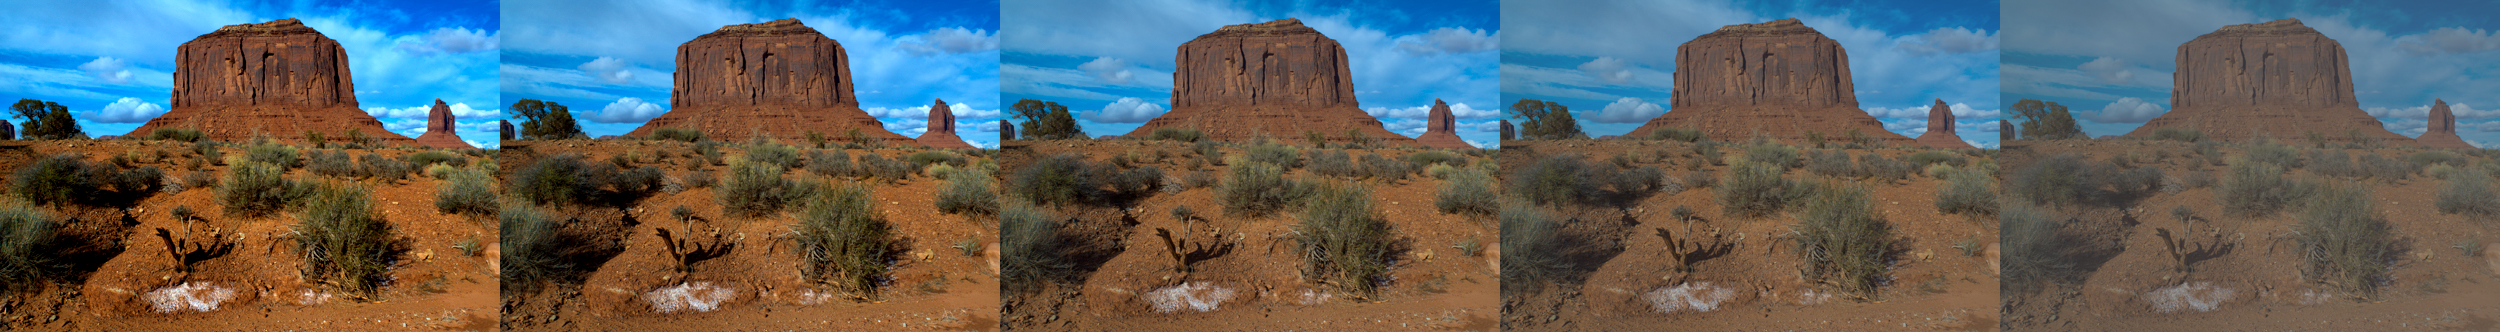

In [6]:
aug_multi(PIL.Image.open('data/artists/FiveK_C/0001.jpg'), [1.5,1.25,1,0.75,0.5],ImageEnhance.Contrast)

In [7]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr,size=128,teps=[1.5,1.25,0.75,0.5]):
        self.path_lr = path_lr
        self.path_hr = path_hr
        self.steps = steps
        self.size = size
        
    def __call__(self, fn,i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, self.size, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        for step in self.steps:
            img1 = ImageEnhance.Brightness(img).enhance(step)
            canvas = PIL.Image.new('RGB', (w, h))
            canvas.paste(img1, (0, 0))
            dest=Path(str(self.path_lr/fn.relative_to(self.path_hr).name).split('.jpg')[0]+f'_br{step}.jpg')
            canvas.save(dest)
            
            img2 = ImageEnhance.Color(img).enhance(step)
            canvas = PIL.Image.new('RGB', (w, h))
            canvas.paste(img2, (0, 0))
            dest=Path(str(self.path_lr/fn.relative_to(self.path_hr).name).split('.jpg')[0]+f'_cr{step}.jpg')
            canvas.save(dest)
            
            img3 = ImageEnhance.Contrast(img).enhance(step)
            canvas = PIL.Image.new('RGB', (w, h))
            canvas.paste(img3, (0, 0))
            dest=Path(str(self.path_lr/fn.relative_to(self.path_hr).name).split('.jpg')[0]+f'_cn{step}.jpg')
            canvas.save(dest)
            
            img4 = ImageEnhance.Sharpness(img).enhance(step)
            canvas = PIL.Image.new('RGB', (w, h))
            canvas.paste(img4, (0, 0))
            dest=Path(str(self.path_lr/fn.relative_to(self.path_hr).name).split('.jpg')[0]+f'_sh{step}.jpg')
            canvas.save(dest)
        

In [8]:
path_hr = path/'FiveK_C'
path_lr = path/'crappy'

In [9]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [10]:
len(path_lr.ls())

80000

In [11]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

In [12]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [25]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/(str(x.name).split('_')[0]+'.jpg'))
           .transform(None, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [26]:
data_gen = get_data(bs,size)

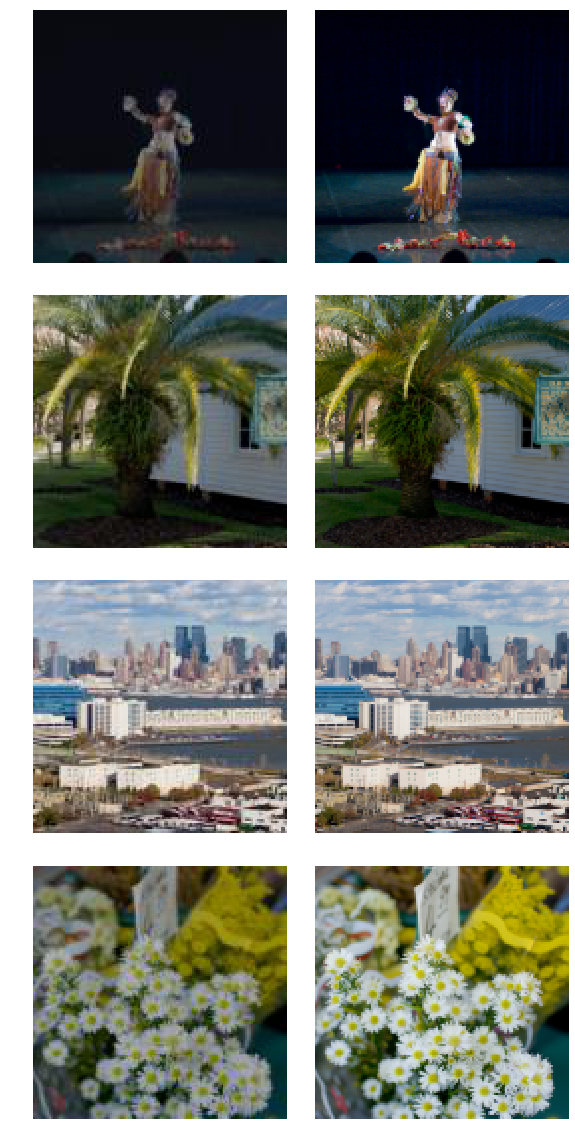

In [27]:
data_gen.show_batch(4)

In [28]:
wd = 1e-3
y_range = (-3.,3.)

In [29]:
loss_gen = MSELossFlat()

In [30]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [31]:
learn_gen = create_gen_learner()

In [32]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.101715,0.085831,07:51
1,0.064630,0.059469,07:45


In [33]:
learn_gen.unfreeze()

In [34]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.055635,0.053514,08:14
1,0.047851,0.045125,08:15
2,0.039448,0.041002,08:15


In [ ]:
learn_gen.show_results(rows=4)

In [36]:
learn_gen.save('gen-pre3')

In [37]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [38]:
path_gen.mkdir(exist_ok=True)

In [39]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [40]:
save_preds(data_gen.fix_dl)

In [ ]:
PIL.Image.open(path_gen.ls()[0])

In [42]:
learn_gen=None
gc.collect()

20

In [ ]:
path.ls()

In [46]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(None, size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [ ]:
data_crit = get_crit_data([name_gen, 'FiveK_C'], bs=bs, size=size)

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [49]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [50]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [51]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

In [53]:
learn_critic.save('critic-pre3')

In [54]:
learn_crit=None
learn_gen=None
gc.collect()

15914

In [ ]:
data_crit = get_crit_data(['crappy', 'FiveK_C'], bs=bs, size=size)

In [56]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre3')

In [57]:
learn_gen = create_gen_learner().load('gen-pre3')

In [58]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [59]:
lr = 1e-4

In [ ]:
learn.fit(40,lr)

In [ ]:
learn.show_results(rows=16)

In [62]:
learn.save('gan-2c')

In [63]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

In [65]:
learn.save('gan-2c')

In [ ]:
learn.show_results(rows=16)

In [4]:
img = open_image('data/artists/crappy/0001_cn0.5.jpg')

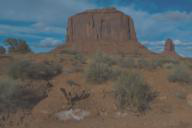

In [7]:
img

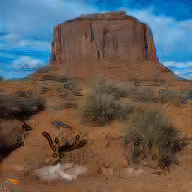

In [123]:
learn.predict(img)[0]